<ipython-input-11-ebf01e7e3792>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Datetime'] = pd.to_datetime(df['FullDate'].dt.strftime('%Y-%m-%d') + ' ' + df['Time'], errors='coerce')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0741 - val_loss: 0.0200
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0196 - val_loss: 0.0182
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0178 - val_loss: 0.0170
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0166 - val_loss: 0.0163
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0165 - val_loss: 0.0155
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0162 - val_loss: 0.0153
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0153 - val_loss: 0.0154
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0161 - val_loss: 0.0145
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0141 - val_loss: 0.0145
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0146 - val_loss: 0.0141
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/s

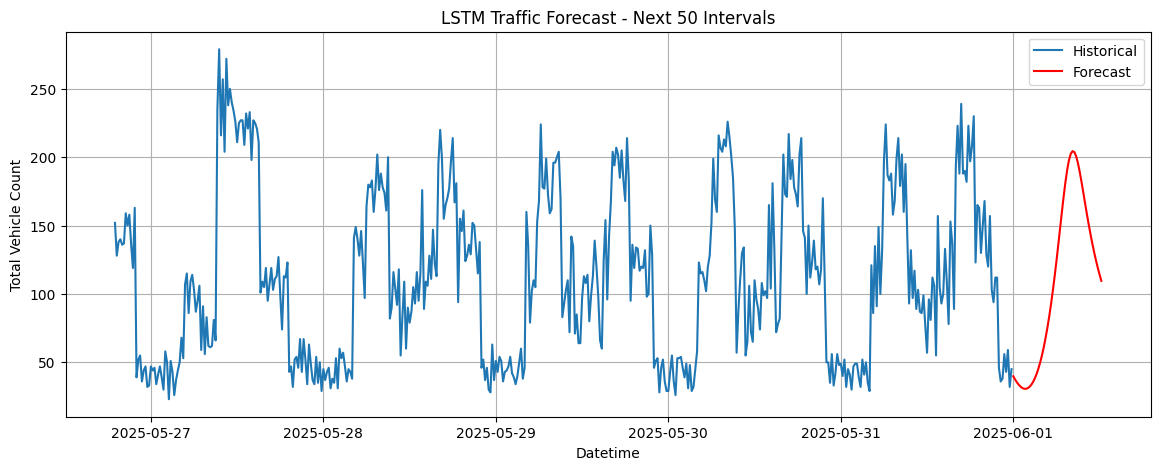

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# STEP 1: Load and prepare data
df = pd.read_csv('Traffic.csv')
df['FullDate'] = pd.to_datetime('2025-05-' + df['Date'].astype(str), errors='coerce')
df['Datetime'] = pd.to_datetime(df['FullDate'].dt.strftime('%Y-%m-%d') + ' ' + df['Time'], errors='coerce')
df = df.dropna(subset=['Datetime'])
df = df.sort_values('Datetime')
df.set_index('Datetime', inplace=True)

# Use only the 'Total' column
data = df['Total'].values.reshape(-1, 1)

# STEP 2: Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# STEP 3: Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 50
X, y = create_sequences(data_scaled, window_size)

# STEP 4: Train-test split
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# STEP 5: Build the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# STEP 6: Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# STEP 7: Forecast the next 50 values
last_sequence = data_scaled[-window_size:]
forecast = []

for _ in range(50):
    pred = model.predict(last_sequence.reshape(1, window_size, 1))
    forecast.append(pred[0, 0])
    last_sequence = np.append(last_sequence[1:], pred, axis=0)

# Inverse scale forecast
forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# STEP 8: Plot results
plt.figure(figsize=(14,5))
plt.plot(df.index[-500:], data[-500:], label='Historical')
future_index = pd.date_range(start=df.index[-1], periods=51, freq='15min')[1:]
plt.plot(future_index, forecast_inverse, label='Forecast', color='red')
plt.title('LSTM Traffic Forecast - Next 50 Intervals')
plt.xlabel('Datetime')
plt.ylabel('Total Vehicle Count')
plt.legend()
plt.grid(True)
plt.show()


Here’s a detailed explanation of the code, breaking down the steps involved in forecasting traffic data using an LSTM model:
1. Import Libraries:

    pandas: Used for data manipulation and analysis.

    numpy: Provides support for arrays and mathematical operations.

    matplotlib.pyplot: Used for plotting graphs.

    MinMaxScaler: Scales the data to a range of [0, 1], necessary for neural network models to perform well.

    LSTM: A type of neural network layer suited for time-series forecasting, part of tensorflow.keras.

2. Load and Prepare Data:

    df = pd.read_csv('/mnt/data/Traffic.csv'): Loads the CSV file containing traffic data into a pandas DataFrame.

    df['FullDate'] = pd.to_datetime('2025-05-' + df['Date'].astype(str), errors='coerce'): Converts the Date column to a datetime object, appending a fixed month (May 2025) to the date string.

    df['Datetime'] = pd.to_datetime(df['FullDate'].dt.strftime('%Y-%m-%d') + ' ' + df['Time'], errors='coerce'): Combines the Date and Time columns into a single datetime column for more precise time-based operations.

    df.dropna(subset=['Datetime']): Drops any rows where the Datetime column has missing values.

    df = df.sort_values('Datetime'): Sorts the data by the Datetime column to ensure chronological order.

    df.set_index('Datetime', inplace=True): Sets the Datetime column as the index for the DataFrame.

Here, the data is now properly formatted with a time-based index, which is crucial for time-series forecasting.
3. Data Normalization:

    scaler = MinMaxScaler(): Initializes the MinMaxScaler to scale the data between 0 and 1.

    data_scaled = scaler.fit_transform(data): Scales the traffic data (the Total vehicle count) to the range [0, 1], which is often required for neural network training.

Normalization helps the model learn better, as neural networks perform better with normalized data.
4. Create Sequences:

    The function create_sequences is designed to create sequences of a fixed window size (50 in this case) from the data. Each sequence will have window_size time steps and the corresponding next value to predict.

    X.append(data[i:i+window_size]): Appends a sequence of window_size time steps to X.

    y.append(data[i+window_size]): Appends the target value (the next value after the sequence) to y.

    return np.array(X), np.array(y): Converts the list of sequences and targets into numpy arrays for further use.

5. Train-Test Split:

    split_index = int(len(X) * 0.8): Divides the data into 80% for training and 20% for testing.

    X_train, X_test = X[:split_index], X[split_index:]: Splits the feature sequences into training and testing data.

    y_train, y_test = y[:split_index], y[split_index:]: Splits the target values into training and testing data.

6. Build the LSTM Model:

    model = Sequential(): Initializes a sequential model.

    model.add(LSTM(64, return_sequences=False, input_shape=(window_size, 1))): Adds an LSTM layer with 64 units. The input shape is (window_size, 1) because each sequence has 50 time steps, and each time step is a single value (total vehicle count).

    model.add(Dense(1)): Adds a dense layer with 1 unit as the output (since we are predicting a single value for each sequence).

    model.compile(optimizer='adam', loss='mse'): Compiles the model using the Adam optimizer and Mean Squared Error (MSE) as the loss function, which is commonly used for regression tasks.

7. Train the Model:

    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test)): Trains the model for 10 epochs, using a batch size of 32. The validation data is provided so the model can be evaluated on the test data during training.

8. Forecast the Next 50 Values:

    last_sequence = data_scaled[-window_size:]: Takes the last window_size values from the scaled data as the starting point for forecasting.

    for _ in range(50): Loops 50 times to predict the next 50 time steps.

        pred = model.predict(last_sequence.reshape(1, window_size, 1)): Uses the trained model to predict the next value.

        forecast.append(pred[0, 0]): Appends the predicted value to the forecast list.

        last_sequence = np.append(last_sequence[1:], pred, axis=0): Updates the last_sequence by removing the first value and adding the predicted value, so the model can forecast the next value based on the most recent sequence.

Forecasting is done iteratively, where each new prediction is used as part of the input for the next prediction.
9. Inverse Scaling:

    forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)): Inverse scales the forecasted values to their original scale (vehicle counts), so they can be interpreted in the same way as the input data.

10. Plot Results:

    plt.plot(df.index[-500:], data[-500:], label='Historical'): Plots the last 500 historical data points.

    plt.plot(future_index, forecast_inverse, label='Forecast', color='red'): Plots the forecasted values for the next 50 intervals.

    plt.title('LSTM Traffic Forecast - Next 50 Intervals'): Adds a title to the plot.

    plt.xlabel('Datetime'): Adds a label to the x-axis.

    plt.ylabel('Total Vehicle Count'): Adds a label to the y-axis.

    plt.legend(): Displays the legend.

    plt.grid(True): Adds a grid to the plot for better readability.

Summary:

This code performs time-series forecasting using an LSTM (Long Short-Term Memory) neural network. The main steps include:

    Loading and preparing the data,

    Normalizing the values to the range [0, 1],

    Creating sequences of historical data to feed the LSTM model,

    Splitting the data into training and testing sets,

    Building and training the LSTM model, and

    Using the trained model to forecast the next 50 data points (traffic counts).

Finally, the code plots both the historical and forecasted data to visualize the prediction.

In [ ]:
pip install pandas
pip install numpy
pip install matplotlib
pip install scikit-learn
pip install tensorflow
